In [1]:
#!pip install seaborn
#!pip3 install matplotlib==2.2.2

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 28})

from pymongo import MongoClient

# Load Dataset

In [4]:
conn = MongoClient('140.115.53.147', 27017)
conn.database_names()

['AU_106_2_BIO',
 'AU_106_2_SE',
 'CYCU_1031SP',
 'CYCU_1041SP',
 'CYCU_1042OS',
 'CYCU_1051SP',
 'CYCU_1052OS',
 'KU_dataset_1',
 'KU_dataset_2',
 'NCU_CHKA',
 'NCU_CHKB',
 'NCU_ETS',
 'NCUx107_Pre_college_calculas',
 'OULAD',
 'admin',
 'config',
 'local',
 'test']

# AU 106 Bio

In [33]:
db = conn['AU_106_2_BIO']
collection = db['AU_106_2_BIO_BookRollLog.csv']
au_1062bio_clickstream = pd.DataFrame(list(collection.find()))
au_1062bio_clickstream.head(3)

,_id,contents_id,contents_name,description,device_code,log_id,marker_color,marker_position,marker_text,memo_text,operation_date,operation_name,page_no,process_code,user_id,version
0,5baccd5e98d846d79448be5d,06409663226af2f3114485aa4e0a23b4,1062_YCS_Biology_CH19,NaN,NaN,67058,NaN,NaN,NaN,NaN,2018/4/25 01:20,REGIST CONTENTS,22,NaN,angelashih@Moodle,1
1,5baccd5e98d846d79448be5e,06409663226af2f3114485aa4e0a23b4,1062_YCS_Biology_CH19,NaN,pc,67069,NaN,NaN,NaN,NaN,2018/4/25 01:22,OPEN,1,23.0,angelashih@Moodle,1
2,5baccd5e98d846d79448be5f,06409663226af2f3114485aa4e0a23b4,1062_YCS_Biology_CH19,NaN,pc,67070,NaN,NaN,NaN,NaN,2018/4/25 01:22,NEXT,1,3.0,angelashih@Moodle,1


In [34]:
au_1062bio_clickstream['date'], au_1062bio_clickstream['time'] = au_1062bio_clickstream['operation_date'].str.split(' ', 1).str
au_1062bio_clickstream = au_1062bio_clickstream[['_id', 'date']]
au_1062bio_clickstream.head(3)

,_id,date
0,5baccd5e98d846d79448be5d,2018/4/25
1,5baccd5e98d846d79448be5e,2018/4/25
2,5baccd5e98d846d79448be5f,2018/4/25


In [35]:
au_1062bio_clickstream = au_1062bio_clickstream.groupby(['_id', 'date']).size().reset_index(name='counts')
au_1062bio_clickstream.head(3)

,_id,date,counts
0,5baccd5e98d846d79448be5d,2018/4/25,1
1,5baccd5e98d846d79448be5e,2018/4/25,1
2,5baccd5e98d846d79448be5f,2018/4/25,1


In [37]:
db = conn['AU_106_2_BIO']
collection = db['AU_106_2_BIO_final_score.csv']
au_1062bio_score = pd.DataFrame(list(collection.find()))
au_1062bio_score.head(10)
#au_1062bio_score[au_1062bio_score['_id']=='5baccd5e98d846d79448be5d']

,_id,�`���Z,�Ǹ�
0,5badbbc29e0c6c62033dafb3,80,106013004
1,5badbbc29e0c6c62033dafb4,81,106013012
2,5badbbc29e0c6c62033dafb5,82,106013013
3,5badbbc29e0c6c62033dafb6,81,106013023
4,5badbbc29e0c6c62033dafb7,60,106013024
5,5badbbc29e0c6c62033dafb8,81,106013025
6,5badbbc29e0c6c62033dafb9,79,106013026
7,5badbbc29e0c6c62033dafba,83,106013027
8,5badbbc29e0c6c62033dafbb,78,106013028
9,5badbbc29e0c6c62033dafbc,82,106013029


In [28]:
au_1062bio = pd.merge(au_1062bio_clickstream, au_1062bio_score, on='_id')
au_1062bio.head(3)

,_id,date,counts,�`���Z,�Ǹ�


KeyError: 'score'

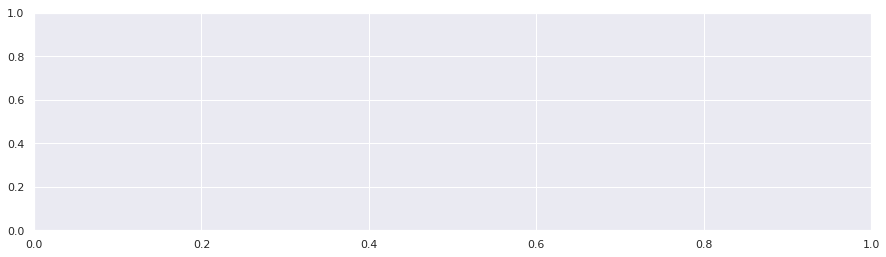

In [62]:

fig1, ax1 = plt.subplots(figsize=(15, 4))
pivot = au_1062bio.pivot(index='_id', columns='date', values='score')
pivot = pivot.fillna(0).T

sns.set()
ax1 = sns.heatmap(pivot, 
                  cbar_kws={'label': 'Score'}, 
                  cmap='GnBu', 
                  linewidths=0.5, 
                  linecolor='gray')

sns.set(font_scale=0.9)

ax1.set_yticklabels(pivot.index, rotation=0)
fig1.tight_layout()
fig1.savefig('./images/au_106bio_students_score_week.png', dpi=300)

In [38]:
sns.set(style='white')

def corrfunc(x, y, **kws):
    r, p = stats.pearsonr(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate('r = {:.2f} '.format(r) + p_stars,
              xy=(0.05, 0.9), xycoords=ax.transAxes)

def annotate_colname(x, **kws):
    ax = plt.gca()
    print(x)
    ax.annotate(x.name, xy=(0.05, 0.9), xycoords=ax.transAxes,
              fontweight='bold')

def cor_matrix(df):
    g = sns.PairGrid(df, palette=['red'])
    
  # Use normal regplot as `lowess=True` doesn't provide CIs.
    g.map_upper(sns.regplot, scatter_kws={'s':10})
    g.map_diag(sns.distplot)
    g.map_lower(sns.kdeplot, cmap='Blues_d')
    g.map_lower(corrfunc)
    g.map_diag(annotate_colname)
  # Remove axis labels, as they're in the diagonals.
    for ax in g.axes.flatten():
        ax.set_ylabel('')
        ax.set_xlabel('')
    return g

<Figure size 1080x1080 with 0 Axes>

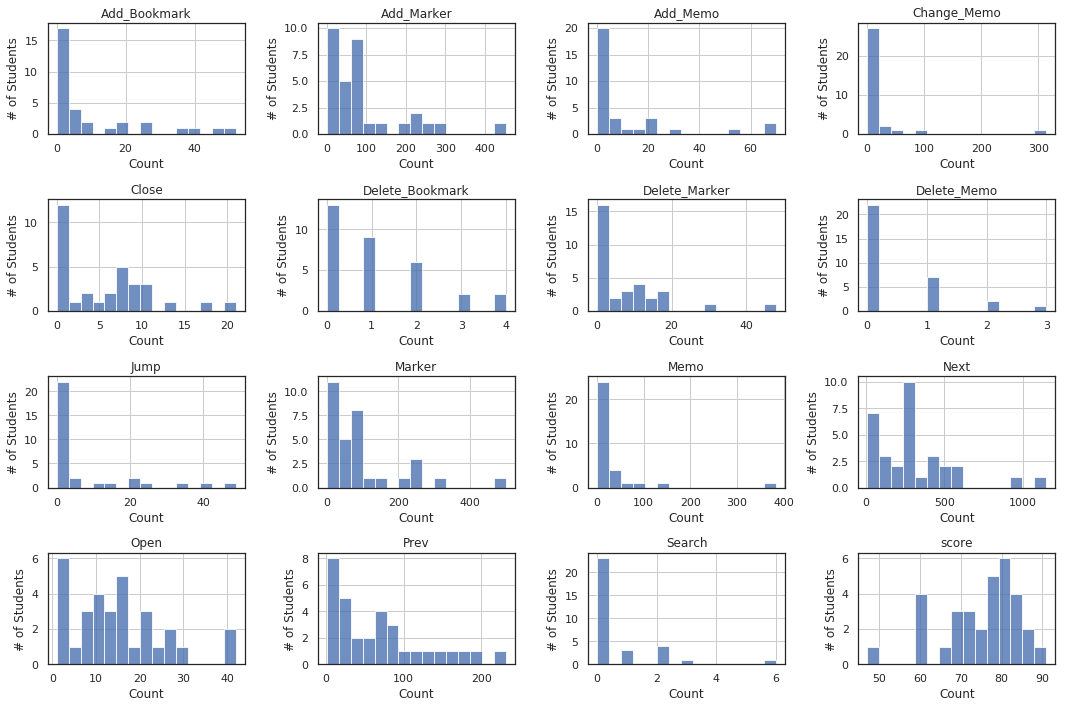

In [45]:

db = conn['AU_106_2_BIO']
collection = db['AU_106_2_BIO_feature_and_score.csv']
au_1062bio_feature = pd.DataFrame(list(collection.find()))
au_1062bio_feature = au_1062bio_feature.drop(['username'], axis=1)

plt.figure(figsize=(15, 15))
ax = au_1062bio_feature.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
plt.savefig('./images/au_1062bio_feature_dist.png', dpi=300)

# AU 106 SE

In [47]:
db = conn['AU_106_2_SE']

In [54]:

collection = db['AU_106_2_SE_BookRollLog.csv']
au_1062se_clickstream = pd.DataFrame(list(collection.find()))

au_1062se_clickstream['date'], au_1062se_clickstream['time'] = au_1062se_clickstream['operation_date'].str.split(' ', 1).str
au_1062se_clickstream = au_1062se_clickstream[['_id', 'date']]
au_1062se_clickstream = au_1062se_clickstream.groupby(['_id', 'date']).size().reset_index(name='counts')
au_1062se_clickstream.head(3)

,_id,date,counts
0,5baccd6098d846d79449175d,2018-04-10,1
1,5baccd6098d846d79449175e,2018-04-10,1
2,5baccd6098d846d79449175f,2018-04-11,1


In [59]:
collection = db['AU_106_2_SE_score.csv']
au_1062se_score = pd.DataFrame(list(collection.find()))
au_1062se_score = au_1062se_score[['_id', 'final_score']]
au_1062se_score.head(3)

,_id,final_score
0,5baccd6198d846d794494019,32.50
1,5baccd6198d846d79449401a,36.40
2,5baccd6198d846d79449401b,60.03


In [60]:
au_1062se = pd.merge(au_1062se_clickstream, au_1062se_score, on='_id')
au_1062se.head(3)

,_id,date,counts,final_score


ValueError: zero-size array to reduction operation minimum which has no identity

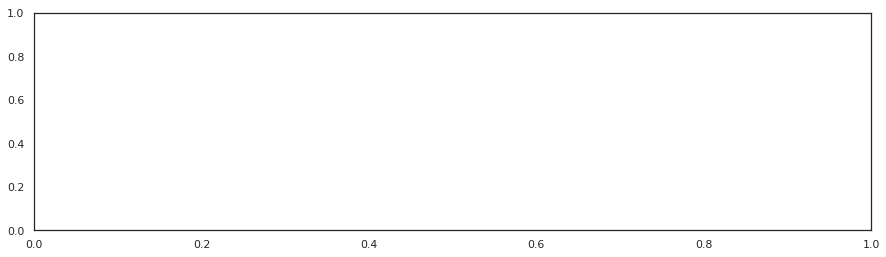

In [61]:

fig1, ax1 = plt.subplots(figsize=(15, 4))
pivot = au_1062se.pivot(index='_id', columns='date', values='final_score')
pivot = pivot.fillna(0).T

sns.set()
ax1 = sns.heatmap(pivot, 
                  cbar_kws={'label': 'Score'}, 
                  cmap='GnBu', 
                  linewidths=0.5, 
                  linecolor='gray')

sns.set(font_scale=0.9)
ax1.set_yticklabels(pivot.index, rotation=0)
fig1.tight_layout()
fig1.savefig('./images/au_106se_students_score_week.png', dpi=300)

<Figure size 1080x1080 with 0 Axes>

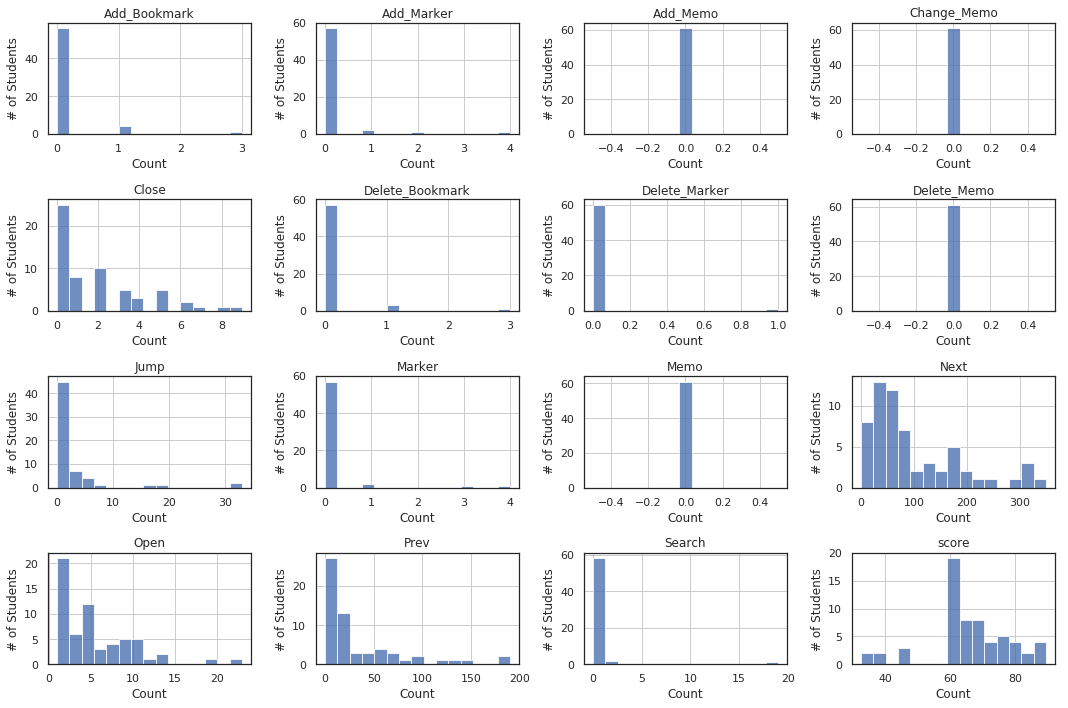

In [44]:

collection = db['AU_106_2_SE_feature_and_score.csv']
au_1062bio_feature = pd.DataFrame(list(collection.find()))
au_1062bio_feature = au_1062bio_feature.drop(['username'], axis=1)

plt.figure(figsize=(15, 15))
ax = au_1062bio_feature.hist(alpha=0.8, bins=15, figsize=(15, 10))

for array in ax:
    for subplot in array:
        subplot.set_ylabel('# of Students')
        subplot.set_xlabel('Count')

plt.tight_layout()
plt.savefig('./images/au_1062se_feature_dist.png', dpi=300)